In [1]:
import glob
import numpy as np

In [6]:
def streamflow(dbc,meta): #function to obtain time series of gauged streamflow. 
    #meta is a numerical selector for where meta data ends and measurements of streamflow in the text file begins.
    #dbc is drainage basin code
    y = []
    with open(f'../nldas/streamz__{dbc}.txt','r') as f:
        for x in f:
            y.append(x)
    y = np.asarray(y)
    print(dbc)
    print('number of lines in text file',y.shape)

    streamflows = y[meta:] #gets rid of meta data, empirically derived

    ## removes tabs, splits words into chunks
    z = []
    for idx,x in enumerate(streamflows):
        y = x.split('\t')
        z.append(y)
    z = np.asarray(z)


    #creates table with labels
    a = np.expand_dims(np.asarray(['Gov Ent','Gage ID','Acq Date','cubic ft/s','unknown']),0)
    b = np.vstack((a,z))
    print(b[1])
    print(b[-1])
    # b = b[:-5] #gets rid of dates we don't want
    # print(b[1],'\n',b[-1])

    #takes column 4 only (discharge) and replaces numbers that aren't integers with dummy number.
    cfs = b[1:,3]
    d = np.empty((0))
    empty_count = 0
    for x in cfs:
        try:
            d = np.append(d,int(x))
        except:
            empty_count+=1
            d = np.append(d,-12345678)
    print(f"empty count: \t {empty_count}\n")
    return d


### calling the streamflow function for these four basin codes.
x = ['br','co','ct','ms']

#initalizes empty array of length 2617.
flows = np.empty((0,2617))

for idx,i in enumerate(x):
    if (idx==0):
        sf = streamflow(i,30)
        
        #adds basin streamflow time series to list of time series (there will be four here each of length 2617)
        flows = np.vstack((flows,sf.reshape(1,-1)))
    elif idx == 1:
        sf = streamflow(i,29)
        flows = np.vstack((flows,sf.reshape(1,-1)))
    else:
        sf = streamflow(i,31)
        flows = np.vstack((flows,sf.reshape(1,-1)))
    # #grabs date column        
    # dte = b[1:,2]

    # ##turns cubic feet per second to tensor for training with larsonet.
    # cfs0 = torch.from_numpy(np.float32(cfs)).unsqueeze(1).unsqueeze(1).unsqueeze(1)
    # torch.save(cfs0,'ms_cfs.pt')
    # np.save('ms_dte.npy',dte)
print(f"flows shape: {flows.shape}")

times = np.arange(np.datetime64('2015-01-01'),
                  np.datetime64('2022-03-02'), np.timedelta64(1, 'D'))

# np.save("br_co_ct_ms.npy",flows)
np.save("br_co_ct_ms_times.npy",times)

br
number of lines in text file (2647,)
['USGS' '10039500' '2015-01-01' '125' 'A:e\n']
['USGS' '10039500' '2022-03-01' '132' 'P:e\n']
empty count: 	 257

co
number of lines in text file (2646,)
['USGS' '09429600' '2015-01-01' '340' 'A\n']
['USGS' '09429600' '2022-03-01' '377' 'A\n']
empty count: 	 0

ct
number of lines in text file (2648,)
['USGS' '01193050' '2015-01-01' '33400' 'A\n']
['USGS' '01193050' '2022-03-01' '' '']
empty count: 	 15

ms
number of lines in text file (2648,)
['USGS' '07374000' '2015-01-01' '345000' 'A\n']
['USGS' '07374000' '2022-03-01' '704000' 'P']
empty count: 	 1

flows shape: (4, 2617)


In [14]:
br = flows[0]
co = flows[1]
ct = flows[2]
ms = flows[3]

times = np.arange(np.datetime64('2015-01-01'),
                  np.datetime64('2022-03-02'), np.timedelta64(1, 'D'))

In [15]:
def nonan(i):
    return np.where(i<0,np.nan,i)
def countnonan(i):
    j = np.where(i<0,0,1)
    return np.sum(j)
def countnan(i):
    j = np.where(i<0,1,0)
    return np.sum(j)
def zscore_out_devs(i,devs):
    j = np.nanmean(i)
    k = np.nanstd(i)
    l = (i-j)/k
    m = np.where((l>devs) | (l<-devs),1,0)
    n = np.sum(m)
    return n
def zscore_in(i,devs):
    j = np.nanmean(i)
    k = np.nanstd(i)
    l = (i-j)/k
    m = np.where((l<=devs) & (l>=-devs),1,0)
    n = np.sum(m)
    return n

In [21]:
basins = [br, co, ct, ms]
bas_str = ['Bear River','Colorado','Connecticut','Mississippi']
for idx,x in enumerate(basins):
    
    print(f"\033[4m{bas_str[idx]}\033[0m")
    print(f"{len(x)}\t\t\ttotal measurements")
    print(f"\n{countnonan(x)}\t\t\t# of acceptable measurements")
    print(f"{countnan(x)}\t\t\t# of unacceptable measurements")
    print(f"{round(np.nanmean(nonan(x)))} \t\t\taverage discharge (cubic feet/second)")
    print(f"{round(np.nanstd(nonan(x)))} \t\t\tstandard deviation (σ) of discharge")
    print(f"{zscore_in(nonan(x),1)} / {round(zscore_in(nonan(x),1) / countnonan(x),4)*100}%\t\t(number / % acceptable) inside 1σ")
    print(f"{zscore_out_devs(nonan(x),1)} / {round(zscore_out_devs(nonan(x),1) / countnonan(x)*100,4)}%\t\t(number / % acceptable) outside 1σ")
    print(f"{zscore_out_devs(nonan(x),2)} / {round(zscore_out_devs(nonan(x),2) / countnonan(x)*100,4)}%\t\t(number / % acceptable) outside 2σ")
    print(f"{zscore_out_devs(nonan(x),3)} / {round(zscore_out_devs(nonan(x),3) / countnonan(x)*100,4)}%\t\t(number / % acceptable) outside 3σ")
    print(f"{zscore_out_devs(nonan(x),4)} / {round(zscore_out_devs(nonan(x),4) / countnonan(x)*100,4)}%\t\t(number / % acceptable) outside 4σ")
    print(f"{zscore_out_devs(nonan(x),5)} / {round(zscore_out_devs(nonan(x),5) / countnonan(x)*100,4)}%\t\t(number / % acceptable) outside 5σ")
    print(f"{zscore_out_devs(nonan(x),6)} / {round(zscore_out_devs(nonan(x),6) / countnonan(x)*100,4)}%\t\t(number / % acceptable) outside 6σ")
    print(f"{zscore_out_devs(nonan(x),7)} / {round(zscore_out_devs(nonan(x),7) / countnonan(x)*100,4)}%\t\t(number / % acceptable) outside 7σ")
    print(f"{zscore_out_devs(nonan(x),8)} / {round(zscore_out_devs(nonan(x),8) / countnonan(x)*100,4)}%\t\t(number / % acceptable) outside 8σ")
    print(f"{zscore_out_devs(nonan(x),9)} / {round(zscore_out_devs(nonan(x),9) / countnonan(x)*100,4)}%\t\t(number / % acceptable) outside 9σ")
    print(f"{zscore_out_devs(nonan(x),10)} / {round(zscore_out_devs(nonan(x),10) / countnonan(x)*100,4)}%\t\t(number / % acceptable) outside 10σ")
    print(f"{zscore_out_devs(nonan(x),11)} / {round(zscore_out_devs(nonan(x),11) / countnonan(x)*100,4)}%\t\t(number / % acceptable) outside 11σ")
    print(f"{zscore_out_devs(nonan(x),12)} / {round(zscore_out_devs(nonan(x),12) / countnonan(x)*100,4)}%\t\t(number / % acceptable) outside 12σ")
    print(f"{zscore_out_devs(nonan(x),13)} / {round(zscore_out_devs(nonan(x),13) / countnonan(x)*100,4)}%\t\t(number / % acceptable) outside 13σ\n")

Bear River
2617			total measurements

2360			# of acceptable measurements
257			# of unacceptable measurements
382 			average discharge (cubic feet/second)
487 			standard deviation (σ) of discharge
2153 / 91.23%		(number / % acceptable) inside 1σ
207 / 8.7712%		(number / % acceptable) outside 1σ
131 / 5.5508%		(number / % acceptable) outside 2σ
82 / 3.4746%		(number / % acceptable) outside 3σ
41 / 1.7373%		(number / % acceptable) outside 4σ
14 / 0.5932%		(number / % acceptable) outside 5σ
0 / 0.0%		(number / % acceptable) outside 6σ
0 / 0.0%		(number / % acceptable) outside 7σ
0 / 0.0%		(number / % acceptable) outside 8σ
0 / 0.0%		(number / % acceptable) outside 9σ
0 / 0.0%		(number / % acceptable) outside 10σ
0 / 0.0%		(number / % acceptable) outside 11σ
0 / 0.0%		(number / % acceptable) outside 12σ
0 / 0.0%		(number / % acceptable) outside 13σ

Colorado
2617			total measurements

2617			# of acceptable measurements
0			# of unacceptable measurements
510 			average discharge (cubic f

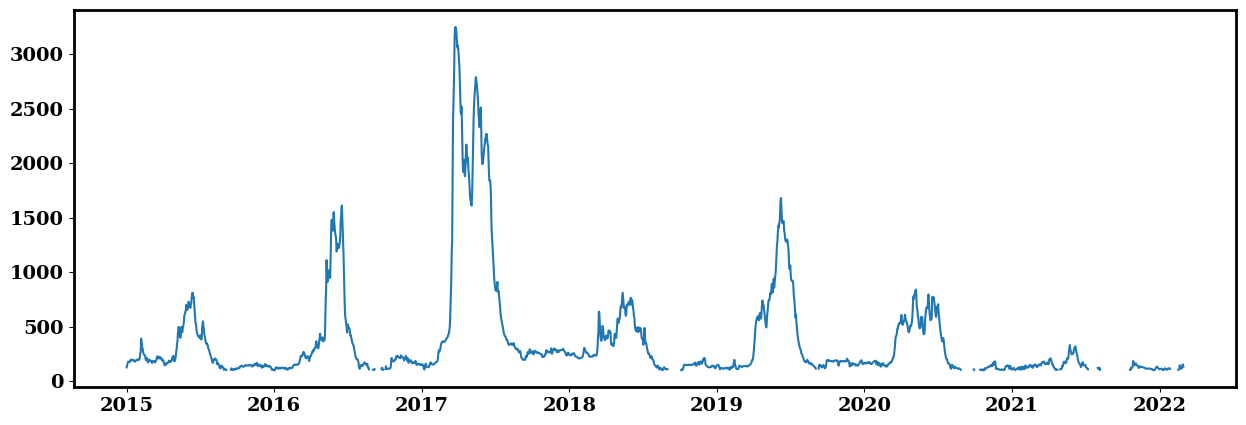

In [21]:
plt.figure(figsize=(15,5))
plt.plot(times,nonan(br))

In [14]:
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "DejaVu Serif"
plt.rcParams["font.size"] = 14
plt.rcParams['figure.dpi'] = 100
plt.rcParams['axes.linewidth'] = 2
plt.rcParams["font.weight"] = "bold"

In [1]:
# import matplotlib.gridspec as gridspec

# times = np.arange(np.datetime64('2015-01-01'),
#                   np.datetime64('2022-03-02'), np.timedelta64(1, 'D'))
# # plt.figure(figsize=(15,5))
# # for i in flows:
# #     j = np.where(i<0,np.nan,i)
# #     k = np.nanmean(j)
# #     l = np.nanstd(j)
# #     j = (j-k)/l
# #     # plt.figure()
# #     plt.plot(times,j)
# # plt.xticks(rotation=45);

# fig,ax = plt.subplots(1,1,figsize=(17,17))
# plt.xlim([-5,12])
# plt.ylim([0,1000])
# for i in flows:
#     j = np.where(i<0,np.nan,i)
#     k = np.nanmean(j)
#     l = np.nanstd(j)
#     j = (j-k)/l
#     plt.hist(j,bins=50,histtype='step',linewidth=4)

# plt.legend(['Bear River','Colorado','Connecticut','Mississippi'],loc='upper left',frameon=False)
# # plt.xlabel('z-score of basin streamflow')

# # xy = (-.5,940)
# # plt.annotate('histograms \nz-scored hydrographs', xy=xy, xycoords='data',
# #             xytext=xy, textcoords='data',
# #              horizontalalignment='center'
# #             )

# # plt.annotate('histograms of \nz-scored \nstreamflow \nmeasurements', xy=(0,800), xycoords='data',
# #              xytext=(.5,700), textcoords='data',
# #              arrowprops=dict(facecolor='black',shrink=0.05),
# #              horizontalalignment='left',verticalalignment='top',
# #             )
# # plt.annotate('', xy=(1,500), xycoords='data',
# #              xytext=(1.5,600), textcoords='data',
# #              arrowprops=dict(facecolor='black',shrink=0.05),
# #              horizontalalignment='left',verticalalignment='top',
# #             )

# # xy = (6.5,960)
# # plt.annotate('z-scored hydrographs', xy=xy, xycoords='data',
# #             xytext=xy, textcoords='data',
# #             )



# bounds = np.array([0.4, 0.15, 0.10, 0.705])
# colors = ['tab:blue','tab:orange','tab:green','tab:red']
# for idx,i in enumerate(flows):
#     j = np.where(i<0,np.nan,i)
#     k = np.nanmean(j)
#     l = np.nanstd(j)
#     j = (j-k)/l
#     plt.axes(bounds + (idx+1)*np.array([.10,0,0,0]))
#     plt.xticks([])
#     if idx != 0:
#         plt.yticks([])
#     plt.plot(np.flip(j),np.flip(times),colors[idx])
#     plt.gca().invert_yaxis()

# # fig = plt.figure(figsize=(20,10))
# # gs = gridspec.GridSpec(1,5,width_ratios=[1,.1,.1,.1,.1])

# # ax0 = fig.add_subplot(gs[0, 0])
# # for i in flows:
# #     j = np.where(i<0,np.nan,i)
# #     k = np.nanmean(j)
# #     l = np.nanstd(j)
# #     j = (j-k)/l
# #     plt.hist(j,bins=50)
# # # plt.title('Bear River',fontsize=fontsize,fontweight='bold')
# # # plt.ylabel('Surface \nFlow',rotation=0, labelpad=50,fontsize=fontsize,fontweight='bold'); plt.xlabel(''); 
# # # plt.xticks(fontsize=fontsize); plt.yticks(fontsize=fontsize)

# # ax1 = fig.add_subplot(gs[0, 1])
# # plt.plot(np.flip(j),np.flip(times),colors[0])
# # plt.xticks([])
# # # plt.ylabel('Subsurface \nFlow',rotation=0, labelpad=50,fontsize=fontsize,fontweight='bold'); plt.xlabel(''); 
# # # plt.xticks(fontsize=fontsize); plt.yticks(fontsize=fontsize)

# # ax2 = fig.add_subplot(gs[0, 2])
# # plt.plot(np.flip(j),np.flip(times),colors[1])
# # plt.xticks([])
# # plt.yticks([])
# # # plt.title('Colorado',fontsize=fontsize,fontweight='bold')
# # # plt.xticks(fontsize=fontsize); plt.yticks(fontsize=fontsize)

# # ax3 = fig.add_subplot(gs[0, 3])
# # plt.plot(j,times)
# # plt.xticks([])
# # plt.yticks([])


# # ax4 = fig.add_subplot(gs[0, 4])
# # plt.plot(j,times)
# # plt.xticks([])
# # plt.yticks([])

# # # plt.xticks(fontsize=fontsize); plt.yticks(fontsize=fontsize)


# # # cbar = plt.colorbar(plt7,cax=plt.subplot(gs[2,1:3]),orientation='horizontal')
# # # cbar.ax.set_title('kg/$\mathregular{m^2}$',fontsize=fontsize,y=-4,fontweight='bold')
# # # cbar.ax.tick_params(labelsize=fontsize) 

# # plt.tight_layout()
# # # plt.suptitle('yo',y=.91,x=.47,fontsize=24)
# plt.savefig('../files_for_paper/fig3.png',bbox_inches='tight')